In [26]:
import pandas as pd
import numpy as np
import re
import nltk

# For text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# For vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob


# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


# Download NLTK data files (only the first time)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malfridurannaeiriksdottir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
df = pd.read_csv('../data/akereviewsdataset.csv')

In [28]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join back into a string
    return ' '.join(words)

df['clean_text'] = df['text_'].apply(preprocess_text)


In [29]:
# Text length (number of words)
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Sentiment score using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df['sentiment_score'] = df['clean_text'].apply(vader_sentiment)

# Rating deviation
mean_rating = df['rating'].mean()
df['rating_deviation'] = df['rating'] - mean_rating


In [30]:
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust as needed
X_text = vectorizer.fit_transform(df['clean_text'])


In [31]:
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from scipy import sparse

numerical_features = ['sentiment_score', 'text_length', 'rating_deviation']
scaler = StandardScaler()
X_num = scaler.fit_transform(df[numerical_features])
X_num_sparse = sparse.csr_matrix(X_num)

# Combine text vectors and numerical features
X = hstack([X_text, X_num_sparse])

# Convert to dense array if necessary (for algorithms that don't accept sparse matrices)
X_dense = X.toarray()

# Also, extract the labels for evaluation purposes
y_true = df['label'].apply(lambda x: 1 if x.lower() == 'cg' else 0).values


In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # Adjust the number of components as needed
X_reduced = pca.fit_transform(X_dense)


# K means

2
3
4
5
6
7
8
9


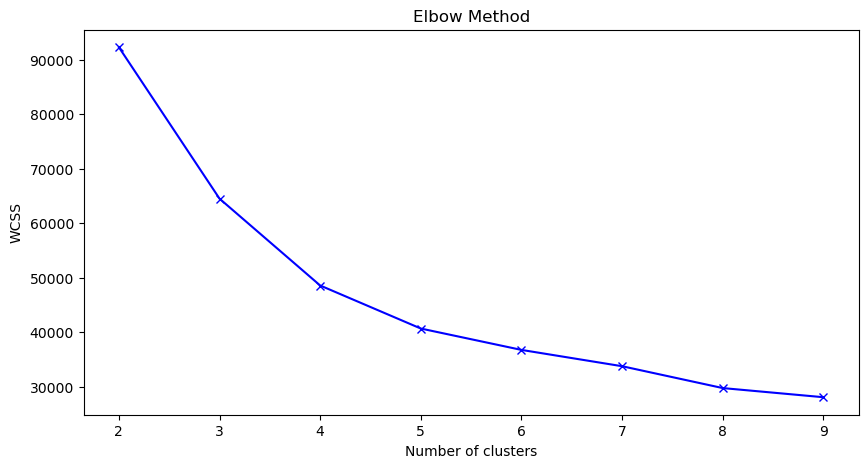

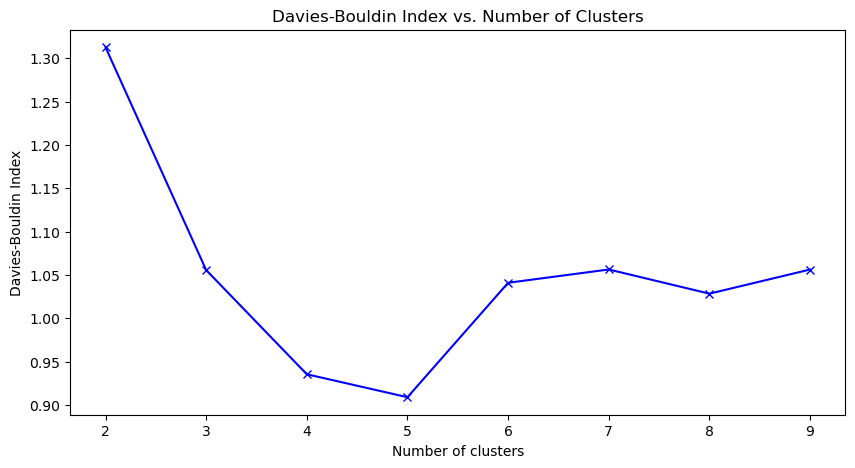

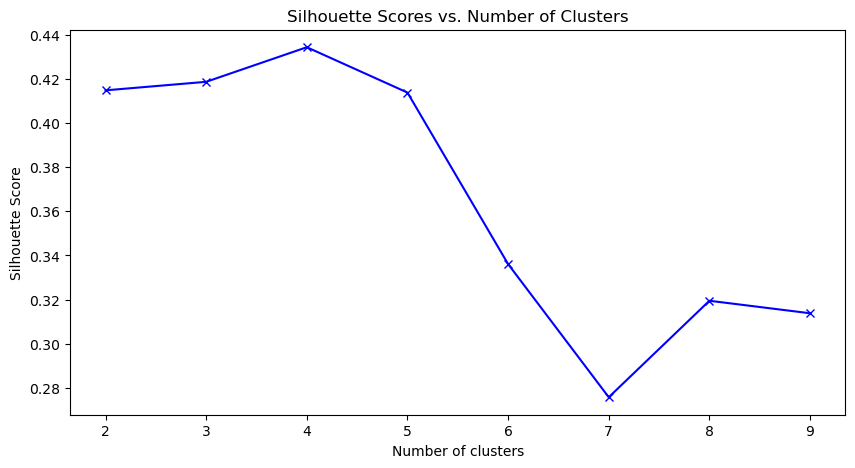

In [33]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

wcss = []
db_scores = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    labels = kmeans.labels_
    wcss.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(X_reduced, labels))
    silhouette_scores.append(silhouette_score(X_reduced, labels))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 5))
plt.plot(K, db_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs. Number of Clusters')
plt.show()


In [34]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_reduced)
df['cluster'] = kmeans.labels_


# DBSCAN

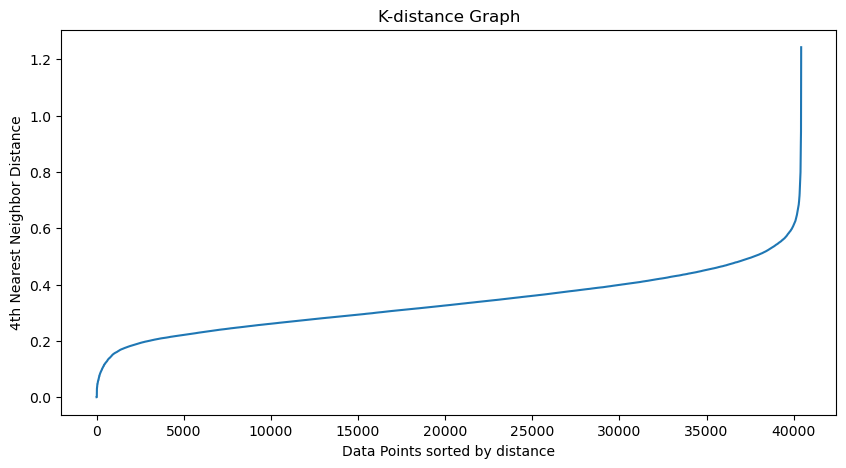

In [35]:
from sklearn.neighbors import NearestNeighbors

# Determine optimal epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

# Choose epsilon (e.g., at the point of maximum curvature)
epsilon = 0.2  # Adjust based on the graph
dbscan = DBSCAN(eps=epsilon, min_samples=5)
dbscan.fit(X_reduced)
df['cluster_dbscan'] = dbscan.labels_


# Hierarchical clustering

In [36]:
# from sklearn.cluster import AgglomerativeClustering

# # Apply hierarchical clustering
# hier_clust = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
# df['cluster_hier'] = hier_clust.fit_predict(X_reduced)


# evaluate

The Davies-Bouldin Index measures the average similarity between clusters. It is defined as the average ratio of within-cluster distances to between-cluster distances. Lower values indicate better clustering (i.e., clusters that are compact and well-separated).

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1. The Silhouette Score for K-Means is moderate, indicating that the clusters are somewhat well-defined.

The Adjusted Rand Index measures the similarity between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. It adjusts for chance grouping of elements and ranges from -1 to 1. Both ARI scores are close to zero, indicating that the clustering results have little to no agreement with the actual labels (CG and OR).

The Adjusted Mutual Information measures the agreement of the two assignments, adjusted for chance. It ranges from 0 to 1. The very low AMI scores indicate that there is virtually no mutual information between your clustering assignments and the true labels.

In [37]:
# For K-Means
db_index_kmeans = davies_bouldin_score(X_reduced, df['cluster'])
print(f'Davies-Bouldin Index for K-Means: {db_index_kmeans:.4f}')

# For DBSCAN
# Ignore noise points labeled as -1
labels_dbscan = df['cluster_dbscan'][df['cluster_dbscan'] != -1]
X_dbscan = X_reduced[df['cluster_dbscan'] != -1]
db_index_dbscan = davies_bouldin_score(X_dbscan, labels_dbscan)
print(f'Davies-Bouldin Index for DBSCAN: {db_index_dbscan:.4f}')

# # For Hierarchical Clustering
# db_index_hier = davies_bouldin_score(X_reduced, df['cluster_hier'])
# print(f'Davies-Bouldin Index for Hierarchical Clustering: {db_index_hier:.4f}')


Davies-Bouldin Index for K-Means: 1.3129
Davies-Bouldin Index for DBSCAN: 1.0475


In [38]:
# For K-Means
sil_score_kmeans = silhouette_score(X_reduced, df['cluster'])
print(f'Silhouette Score for K-Means: {sil_score_kmeans:.4f}')

# For DBSCAN
sil_score_dbscan = silhouette_score(X_dbscan, labels_dbscan)
print(f'Silhouette Score for DBSCAN: {sil_score_dbscan:.4f}')

# For Hierarchical Clustering
# sil_score_hier = silhouette_score(X_reduced, df['cluster_hier'])
# print(f'Silhouette Score for Hierarchical Clustering: {sil_score_hier:.4f}')


Silhouette Score for K-Means: 0.4147
Silhouette Score for DBSCAN: -0.3805


In [39]:
from sklearn.metrics import adjusted_rand_score

# For K-Means
ari_kmeans = adjusted_rand_score(y_true, df['cluster'])
print(f'Adjusted Rand Index for K-Means: {ari_kmeans:.4f}')

# For DBSCAN
# Need to handle noise points (-1 label)
ari_dbscan = adjusted_rand_score(y_true[df['cluster_dbscan'] != -1], labels_dbscan)
print(f'Adjusted Rand Index for DBSCAN: {ari_dbscan:.4f}')

# For Hierarchical Clustering
# ari_hier = adjusted_rand_score(y_true, df['cluster_hier'])
# print(f'Adjusted Rand Index for Hierarchical Clustering: {ari_hier:.4f}')


Adjusted Rand Index for K-Means: 0.0003
Adjusted Rand Index for DBSCAN: 0.0223


In [40]:
from sklearn.metrics import adjusted_mutual_info_score

# For K-Means
ami_kmeans = adjusted_mutual_info_score(y_true, df['cluster'])
print(f'Adjusted Mutual Information for K-Means: {ami_kmeans:.4f}')

# For DBSCAN
ami_dbscan = adjusted_mutual_info_score(y_true[df['cluster_dbscan'] != -1], labels_dbscan)
print(f'Adjusted Mutual Information for DBSCAN: {ami_dbscan:.4f}')

# For Hierarchical Clustering
# ami_hier = adjusted_mutual_info_score(y_true, df['cluster_hier'])
# print(f'Adjusted Mutual Information for Hierarchical Clustering: {ami_hier:.4f}')


Adjusted Mutual Information for K-Means: 0.0004
Adjusted Mutual Information for DBSCAN: 0.0234


# Analyse

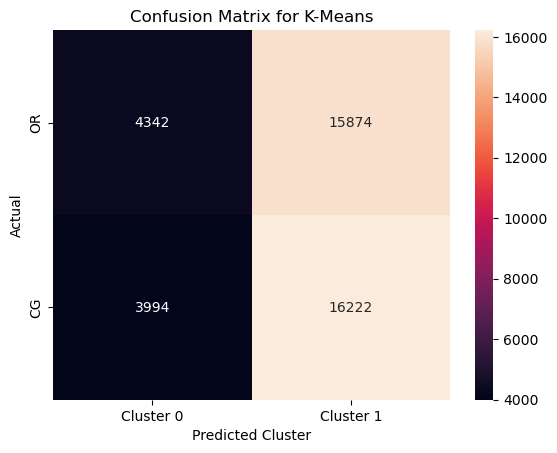

In [41]:
from sklearn.metrics import confusion_matrix

conf_mat_kmeans = confusion_matrix(y_true, df['cluster'])
sns.heatmap(conf_mat_kmeans, annot=True, fmt='d',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['OR', 'CG'])
plt.ylabel('Actual')
plt.xlabel('Predicted Cluster')
plt.title('Confusion Matrix for K-Means')
plt.show()


In [42]:
# For K-Means
cluster_summary = df.groupby('cluster')[numerical_features].mean()
print(cluster_summary)


         sentiment_score  text_length  rating_deviation
cluster                                                
0               0.134566    29.012836         -1.596190
1               0.780437    32.278197          0.414564


# Hyperparameter tuning

In [44]:
import pandas as pd
import numpy as np

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN

# Evaluation metrics
from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
)

# For visualization (if needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [46]:
# Define the range of cluster numbers to try
k_values = range(2, 11)  # From 2 to 10 clusters

# Initialize a list to store results
kmeans_results = []

for k in k_values:
    print(k)
    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    labels = kmeans.labels_
    
    # Compute evaluation metrics
    dbi = davies_bouldin_score(X_reduced, labels)
    silhouette = silhouette_score(X_reduced, labels)
    ari = adjusted_rand_score(y_true, labels)
    ami = adjusted_mutual_info_score(y_true, labels)
    
    # Append results to the list
    kmeans_results.append({
        'Algorithm': 'K-Means',
        'Parameters': f'n_clusters={k}',
        'Davies-Bouldin Index': dbi,
        'Silhouette Score': silhouette,
        'Adjusted Rand Index': ari,
        'Adjusted Mutual Information': ami
    })

# Convert results to a DataFrame
kmeans_df = pd.DataFrame(kmeans_results)


2
3
4
5
6
7
8
9
10


In [49]:
# Define ranges for eps and min_samples
eps_values = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0
min_samples_values = [3, 5, 10]

# Initialize a list to store results
dbscan_results = []

# Initialize a list to store results
dbscan_results = []

for eps in eps_values:
    print(k)
    for min_samples in min_samples_values:
        # Initialize and fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_reduced)
        labels = dbscan.labels_
        
        # Get the set of unique labels (clusters)
        unique_labels = set(labels)
        
        # Exclude noise label (-1) if present
        if -1 in unique_labels:
            unique_labels.remove(-1)
        
        # Check if the clustering produced at least 2 clusters
        if len(unique_labels) >= 2:
            # Filter out noise points (-1 label)
            mask = labels != -1
            labels_filtered = labels[mask]
            X_filtered = X_reduced[mask]
            y_filtered = y_true[mask]
            
            # Compute evaluation metrics
            dbi = davies_bouldin_score(X_filtered, labels_filtered)
            silhouette = silhouette_score(X_filtered, labels_filtered)
            ari = adjusted_rand_score(y_filtered, labels_filtered)
            ami = adjusted_mutual_info_score(y_filtered, labels_filtered)
            
            # Append results to the list
            dbscan_results.append({
                'Algorithm': 'DBSCAN',
                'Parameters': f'eps={eps:.2f}, min_samples={min_samples}',
                'Davies-Bouldin Index': dbi,
                'Silhouette Score': silhouette,
                'Adjusted Rand Index': ari,
                'Adjusted Mutual Information': ami
            })
        else:
            # If clustering is not meaningful, record NaN values
            dbscan_results.append({
                'Algorithm': 'DBSCAN',
                'Parameters': f'eps={eps:.2f}, min_samples={min_samples}',
                'Davies-Bouldin Index': np.nan,
                'Silhouette Score': np.nan,
                'Adjusted Rand Index': np.nan,
                'Adjusted Mutual Information': np.nan
            })

# Convert results to a DataFrame
dbscan_df = pd.DataFrame(dbscan_results)


10
10
10
10
10
10
10
10
10
10


In [50]:
# Combine results from both algorithms
results_df = pd.concat([kmeans_df, dbscan_df], ignore_index=True)

# Sort results for better readability (optional)
results_df.sort_values(by=['Algorithm', 'Parameters'], inplace=True)

# Reset index
results_df.reset_index(drop=True, inplace=True)

# Display the results
print(results_df)


   Algorithm                Parameters  Davies-Bouldin Index  \
0     DBSCAN  eps=0.10, min_samples=10              0.472790   
1     DBSCAN   eps=0.10, min_samples=3              0.669216   
2     DBSCAN   eps=0.10, min_samples=5              0.572688   
3     DBSCAN  eps=0.20, min_samples=10              0.892485   
4     DBSCAN   eps=0.20, min_samples=3              1.162523   
5     DBSCAN   eps=0.20, min_samples=5              1.047459   
6     DBSCAN  eps=0.30, min_samples=10              1.323881   
7     DBSCAN   eps=0.30, min_samples=3              1.187509   
8     DBSCAN   eps=0.30, min_samples=5              1.230825   
9     DBSCAN  eps=0.40, min_samples=10              1.515360   
10    DBSCAN   eps=0.40, min_samples=3              1.163074   
11    DBSCAN   eps=0.40, min_samples=5              1.193317   
12    DBSCAN  eps=0.50, min_samples=10              2.315062   
13    DBSCAN   eps=0.50, min_samples=3              1.356988   
14    DBSCAN   eps=0.50, min_samples=5  

In [51]:
# Set display options for better readability
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the DataFrame
display(results_df)


,Algorithm,Parameters,Davies-Bouldin Index,Silhouette Score,Adjusted Rand Index,Adjusted Mutual Information
0,DBSCAN,"eps=0.10, min_samples=10",0.4728,0.7017,0.0010,0.0218
1,DBSCAN,"eps=0.10, min_samples=3",0.6692,0.4195,0.0051,0.0449
2,DBSCAN,"eps=0.10, min_samples=5",0.5727,0.4786,0.0091,0.0487
3,DBSCAN,"eps=0.20, min_samples=10",0.8925,-0.1585,0.0066,0.0202
4,DBSCAN,"eps=0.20, min_samples=3",1.1625,-0.4038,0.0225,0.0311
5,DBSCAN,"eps=0.20, min_samples=5",1.0475,-0.3805,0.0223,0.0234
6,DBSCAN,"eps=0.30, min_samples=10",1.3239,-0.2801,-0.0149,0.0078
7,DBSCAN,"eps=0.30, min_samples=3",1.1875,-0.5670,-0.0038,0.0281
8,DBSCAN,"eps=0.30, min_samples=5",1.2308,-0.4939,-0.0111,0.0173
9,DBSCAN,"eps=0.40, min_samples=10",1.5154,-0.1017,-0.0067,0.0036


In [52]:
# Save to CSV
results_df.to_csv('clustering_parameter_tuning_results.csv', index=False)
